# Tensorflow DNN - validation performance

## import package

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf

## prepare dataset examples

In [2]:
simpson_img = pd.read_csv('simpson_preproc/simpson_img_list.csv')
print(simpson_img.head())

  classname                         img
0       c34  marge_simpson/pic_0601.jpg
1       c34  marge_simpson/pic_0180.jpg
2       c34  marge_simpson/pic_0196.jpg
3       c34  marge_simpson/pic_0698.jpg
4       c34  marge_simpson/pic_0083.jpg


## plot image example

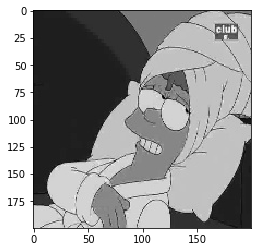

In [3]:
img = cv2.imread('simpson_preproc/' + simpson_img.img.iloc[0], 0)
plt.imshow(img, cmap='gray')

## filter data

In [4]:
simpson_img = simpson_img[simpson_img.img.str.contains('simpson')]

## transform y to one-hot encoder format

In [5]:
simpson_y = pd.get_dummies(simpson_img['classname'], '').as_matrix()
print(simpson_y)

[[0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 ..., 
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]]


## split dataset to training data and testing data

In [6]:
x_train_list, x_test_list, y_train, y_test = train_test_split(simpson_img, simpson_y, test_size=0.1)  ## 將 input_x 和 input_y 各自區分成 training data 和 testing data

## record the dim of img ##
img = cv2.resize(img, (50,50))
img = img.flatten()

print('input_data shape: training {training_shape} ; testing {testing_shape}'.format(
            training_shape=(len(x_train_list), img.shape[0]), 
            testing_shape=(len(x_test_list), img.shape[0])))
print('y_true shape: training {training_shape} ; testing {testing_shape}'.format(
            training_shape=y_train.shape, 
            testing_shape=y_test.shape))

input_data shape: training (6546, 2500) ; testing (728, 2500)
y_true shape: training (6546, 6) ; testing (728, 6)


## define image generator

In [7]:
from sklearn.utils import shuffle 

def simpson_train_batch_generator(x, y, bs, shape):
    x_train = np.array([]).reshape((0, shape))
    y_train = np.array([]).reshape((0, y.shape[1]))
    while True:
        new_ind = shuffle(range(len(x)))
        x = x.take(new_ind)
        y = np.take(y, new_ind, axis=0)
        for i in range(len(x)):
            dir_img = 'simpson_preproc/' + x.img.iloc[i]
            img = cv2.imread(dir_img, 0)
            img = cv2.resize(img, (50,50))
            x_train = np.row_stack([x_train, img.flatten()])
            y_train = np.row_stack([y_train, y[i]])
            if x_train.shape[0] == bs:
                x_batch = x_train.copy()
                x_batch /= 255.
                y_batch = y_train.copy()
                x_train = np.array([]).reshape((0 ,shape))
                y_train = np.array([]).reshape((0 ,y.shape[1]))        
                yield x_batch, y_batch

def simpson_test_batch_generator(x, shape):
    x_test = np.array([]).reshape((0, shape))
    for i in range(len(x)):
        dir_img = 'simpson_preproc/' + x.img.iloc[i]
        img = cv2.imread(dir_img, 0)
        img = cv2.resize(img, (50,50))
        x_test = np.row_stack([x_test, img.flatten()])
    x_test /= 255.      
    return x_test

## testing data generate

In [8]:
x_test = simpson_test_batch_generator(x_test_list, img.shape[0])

# create graph

In [9]:
tf.reset_default_graph() ## 重新 build graph 需要跑這行

## step 1: define placeholder

In [10]:
#### define placeholder ####
input_data = tf.placeholder(dtype=tf.float32, 
                           shape=[None, img.shape[0]],
                           name='input_data')

y_true = tf.placeholder(dtype=tf.float32, 
                        shape=[None, y_train.shape[1]],
                        name='y_true')

## step 2: create variables and operations

In [11]:
#### define variables(weight/bias) ####
x1 = tf.layers.dense(input_data, 256, activation=tf.nn.relu, name='hidden1')
x2 = tf.layers.dense(x1, 128, activation=tf.nn.relu, name='hidden2')
x3 = tf.layers.dense(x2, 64, activation=tf.nn.relu, name='hidden3')
out = tf.layers.dense(x3, y_train.shape[1], name='output')

y_pred = out

## step 3: define loss function and calculate loss

In [12]:
#### calculate loss ####
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred))

## step 4: define optimizer and define variables update operations

In [13]:
#### optimize variables ####
opt = tf.train.AdamOptimizer(learning_rate=0.0001)

update = opt.minimize(loss)
# grad = opt.compute_gradients(loss)
# update = opt.apply_gradients(grad)

## check global variables (optional)

In [14]:
tf.global_variables() ## 檢查 graph 裏的 global variables

[<tf.Variable 'hidden1/kernel:0' shape=(2500, 256) dtype=float32_ref>,
 <tf.Variable 'hidden1/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'hidden2/kernel:0' shape=(256, 128) dtype=float32_ref>,
 <tf.Variable 'hidden2/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'hidden3/kernel:0' shape=(128, 64) dtype=float32_ref>,
 <tf.Variable 'hidden3/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'output/kernel:0' shape=(64, 6) dtype=float32_ref>,
 <tf.Variable 'output/bias:0' shape=(6,) dtype=float32_ref>,
 <tf.Variable 'beta1_power:0' shape=() dtype=float32_ref>,
 <tf.Variable 'beta2_power:0' shape=() dtype=float32_ref>,
 <tf.Variable 'hidden1/kernel/Adam:0' shape=(2500, 256) dtype=float32_ref>,
 <tf.Variable 'hidden1/kernel/Adam_1:0' shape=(2500, 256) dtype=float32_ref>,
 <tf.Variable 'hidden1/bias/Adam:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'hidden1/bias/Adam_1:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'hidden2/kernel/Adam:0' shape=(256, 128) dtype

# run session

## step 1: run global variables initialization

In [15]:
#### init ####
init = tf.global_variables_initializer()

In [16]:
sess = tf.Session()
sess.run(init)

## step 2: run session to update the variables

In [17]:
from tqdm import tqdm_notebook
import time
from sklearn.metrics import accuracy_score

epoch = 100
bs = 32
update_per_epoch = 100

tr_loss = list()
te_loss = list()
tr_acc = list()
te_acc = list()
train_gen = simpson_train_batch_generator(x_train_list, y_train, bs, img.shape[0])

print('start modelling!')

for i in range(epoch):
    
    #### calculate training loss & update variables ####
    training_loss = 0
    training_acc = 0
    bar = tqdm_notebook(range(update_per_epoch))
    for j in bar:
        
        x_batch, y_batch = next(train_gen)
        
        tr_pred, training_loss_batch, _ = sess.run([y_pred, loss, update], feed_dict={
            input_data:x_batch,
            y_true:y_batch
        })
        
        training_loss += training_loss_batch
        
        training_acc_batch = accuracy_score(np.argmax(y_batch, axis=1), np.argmax(tr_pred, axis=1))
        training_acc += training_acc_batch
        
        if j % 5 == 0:
            bar.set_description('loss: %.4g' % training_loss_batch)

    training_loss /= update_per_epoch
    training_acc /= update_per_epoch
    
    #### calculate testing data loss ####
    te_pred, testing_loss = sess.run([y_pred, loss], feed_dict={
        input_data:x_test,
        y_true:y_test
    })
    
    testing_acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(te_pred, axis=1))
    
    tr_loss.append(training_loss)
    te_loss.append(testing_loss)
    tr_acc.append(training_acc)
    te_acc.append(testing_acc)
    
    print('epoch {epochs}: training loss {training_loss} ; testing loss {testing_loss}'.format(
            epochs=(i+1), 
            training_loss=training_loss,
            testing_loss=testing_loss))


start modelling!


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 1: training loss 1.6294182288646697 ; testing loss 1.6017777919769287


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 2: training loss 1.5628544330596923 ; testing loss 1.5741453170776367


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 3: training loss 1.5304683792591094 ; testing loss 1.5246211290359497


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 4: training loss 1.5286772286891936 ; testing loss 1.511791706085205


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 5: training loss 1.5199210846424103 ; testing loss 1.5374623537063599


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 6: training loss 1.4922680747509003 ; testing loss 1.5041203498840332


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 7: training loss 1.4942980265617372 ; testing loss 1.4983805418014526


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 8: training loss 1.4685508382320405 ; testing loss 1.48615562915802


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 9: training loss 1.4783794343471528 ; testing loss 1.482284426689148


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 10: training loss 1.4555825066566468 ; testing loss 1.4855316877365112


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 11: training loss 1.4448217475414276 ; testing loss 1.4887970685958862


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 12: training loss 1.4684121906757355 ; testing loss 1.4640333652496338


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 13: training loss 1.4208729362487793 ; testing loss 1.4688152074813843


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 14: training loss 1.4440905523300172 ; testing loss 1.4585341215133667


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 15: training loss 1.4230467212200164 ; testing loss 1.4718470573425293


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 16: training loss 1.4279058635234834 ; testing loss 1.4725350141525269


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 17: training loss 1.4208273315429687 ; testing loss 1.4455232620239258


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 18: training loss 1.396803379058838 ; testing loss 1.4410953521728516


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 19: training loss 1.3959624528884889 ; testing loss 1.4445903301239014


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 20: training loss 1.3830349451303483 ; testing loss 1.454586148262024


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 21: training loss 1.3804384338855744 ; testing loss 1.4426008462905884


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 22: training loss 1.3695472514629363 ; testing loss 1.4329220056533813


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 23: training loss 1.3664004838466643 ; testing loss 1.442433476448059


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 24: training loss 1.3763285183906555 ; testing loss 1.4256609678268433


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 25: training loss 1.3425939917564391 ; testing loss 1.4103403091430664


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 26: training loss 1.3278158402442932 ; testing loss 1.419893741607666


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 27: training loss 1.3360065865516662 ; testing loss 1.4138848781585693


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 28: training loss 1.3006246256828309 ; testing loss 1.406880497932434


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 29: training loss 1.3288338041305543 ; testing loss 1.3989295959472656


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 30: training loss 1.2912833786010742 ; testing loss 1.4056005477905273


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 31: training loss 1.3041620886325835 ; testing loss 1.4021062850952148


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 32: training loss 1.2963534772396088 ; testing loss 1.3912752866744995


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 33: training loss 1.2662880909442902 ; testing loss 1.4075838327407837


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 34: training loss 1.2526725792884827 ; testing loss 1.5189628601074219


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 35: training loss 1.270885313153267 ; testing loss 1.392448902130127


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 36: training loss 1.2523978132009506 ; testing loss 1.3901423215866089


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 37: training loss 1.237723404765129 ; testing loss 1.3848847150802612


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 38: training loss 1.2350135892629623 ; testing loss 1.3592454195022583


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 39: training loss 1.2061794781684876 ; testing loss 1.3777023553848267


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 40: training loss 1.2178120875358582 ; testing loss 1.4139143228530884


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 41: training loss 1.2159905797243118 ; testing loss 1.3577405214309692


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 42: training loss 1.1827319520711899 ; testing loss 1.3566347360610962


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 43: training loss 1.193025959134102 ; testing loss 1.3526301383972168


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 44: training loss 1.146029658317566 ; testing loss 1.402538776397705


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 45: training loss 1.167446133494377 ; testing loss 1.390800952911377


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 46: training loss 1.162246550321579 ; testing loss 1.3517999649047852


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 47: training loss 1.1243289572000503 ; testing loss 1.3563663959503174


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 48: training loss 1.1200490963459016 ; testing loss 1.348822832107544


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 49: training loss 1.1214154398441314 ; testing loss 1.3654975891113281


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 50: training loss 1.104092053771019 ; testing loss 1.4363540410995483


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 51: training loss 1.1057083249092101 ; testing loss 1.3490233421325684


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 52: training loss 1.0741415494680404 ; testing loss 1.3942080736160278


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 53: training loss 1.0824133938550948 ; testing loss 1.3843964338302612


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 54: training loss 1.043614797592163 ; testing loss 1.3702049255371094


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 55: training loss 1.0789525812864305 ; testing loss 1.365515112876892


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 56: training loss 1.0539265751838685 ; testing loss 1.455161452293396


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 57: training loss 1.0435083293914795 ; testing loss 1.370434045791626


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 58: training loss 1.0302551501989365 ; testing loss 1.3545154333114624


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 59: training loss 1.0261352545022964 ; testing loss 1.344954490661621


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 60: training loss 1.0133841294050216 ; testing loss 1.3616796731948853


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 61: training loss 1.0220410764217376 ; testing loss 1.375570297241211


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 62: training loss 1.0032349991798402 ; testing loss 1.317830204963684


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 63: training loss 0.9947304672002792 ; testing loss 1.3493391275405884


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 64: training loss 0.9628751438856125 ; testing loss 1.3513637781143188


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 65: training loss 0.9711873835325241 ; testing loss 1.3284088373184204


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 66: training loss 0.952055127620697 ; testing loss 1.366824746131897


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 67: training loss 0.9404001605510711 ; testing loss 1.369756817817688


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 68: training loss 0.9542899990081787 ; testing loss 1.475332260131836


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 69: training loss 0.9396512299776077 ; testing loss 1.3734631538391113


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 70: training loss 0.9083223450183868 ; testing loss 1.3286051750183105


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 71: training loss 0.9055347549915314 ; testing loss 1.3541837930679321


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 72: training loss 0.8920459884405136 ; testing loss 1.3482469320297241


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 73: training loss 0.8620839881896972 ; testing loss 1.3625987768173218


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 74: training loss 0.9023756581544876 ; testing loss 1.4016832113265991


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 75: training loss 0.8523010671138763 ; testing loss 1.3330072164535522


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 76: training loss 0.8508361405134202 ; testing loss 1.3227951526641846


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 77: training loss 0.8491001117229462 ; testing loss 1.3578238487243652


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 78: training loss 0.8642182034254074 ; testing loss 1.5501829385757446


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 79: training loss 0.8325318348407745 ; testing loss 1.3507808446884155


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 80: training loss 0.8602410590648651 ; testing loss 1.356566309928894


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 81: training loss 0.8018578678369522 ; testing loss 1.3992432355880737


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 82: training loss 0.8121356469392776 ; testing loss 1.3552007675170898


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 83: training loss 0.7954638794064521 ; testing loss 1.4456403255462646


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 84: training loss 0.7910397988557816 ; testing loss 1.4000697135925293


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 85: training loss 0.7590692764520646 ; testing loss 1.4235650300979614


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 86: training loss 0.7673055067658424 ; testing loss 1.3989285230636597


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 87: training loss 0.7635778835415841 ; testing loss 1.3815908432006836


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 88: training loss 0.7741320049762725 ; testing loss 1.3714567422866821


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 89: training loss 0.7253402349352837 ; testing loss 1.3579764366149902


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 90: training loss 0.7417020210623742 ; testing loss 1.3902968168258667


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 91: training loss 0.7486654192209243 ; testing loss 1.4310823678970337


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 92: training loss 0.7120692846179009 ; testing loss 1.3937478065490723


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 93: training loss 0.7103218653798103 ; testing loss 1.5036797523498535


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 94: training loss 0.7078809654712677 ; testing loss 1.5713682174682617


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 95: training loss 0.6873403984308243 ; testing loss 1.4899214506149292


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 96: training loss 0.6654251450300217 ; testing loss 1.4318057298660278


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 97: training loss 0.66478944927454 ; testing loss 1.4784703254699707


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 98: training loss 0.6717689990997314 ; testing loss 1.3984429836273193


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 99: training loss 0.6628005969524383 ; testing loss 1.383210301399231


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 100: training loss 0.6376493108272553 ; testing loss 1.4120088815689087


## plot model training result

Text(0.5,1,'Accuracy')

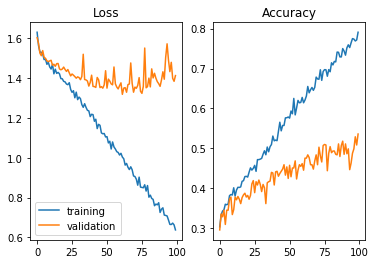

In [18]:
plt.figure(1)
plt.subplot(121)
plt.plot(range(len(tr_loss)), tr_loss, label='training')
plt.plot(range(len(te_loss)), te_loss, label='validation')
plt.title('Loss')
plt.legend(loc='best')
plt.subplot(122)
plt.plot(range(len(tr_acc)), tr_acc, label='training')
plt.plot(range(len(te_acc)), te_acc, label='validation')
plt.title('Accuracy')